
=== Cox 模型汇总 ===
                         coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
age                  0.046017   1.047092  0.009335        0.027721   
ejection_fraction   -0.047592   0.953523  0.010357       -0.067892   
serum_creatinine     0.313232   1.367838  0.071081        0.173915   
serum_sodium        -0.042365   0.958520  0.023691       -0.088799   
anaemia              0.386490   1.471806  0.211522       -0.028085   
diabetes             0.124916   1.133053  0.221873       -0.309947   
high_blood_pressure  0.447271   1.564039  0.214943        0.025991   
smoking              0.120309   1.127845  0.248380       -0.366507   
sex                 -0.177893   0.837032  0.244679       -0.657455   

                     coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age                        0.064313             1

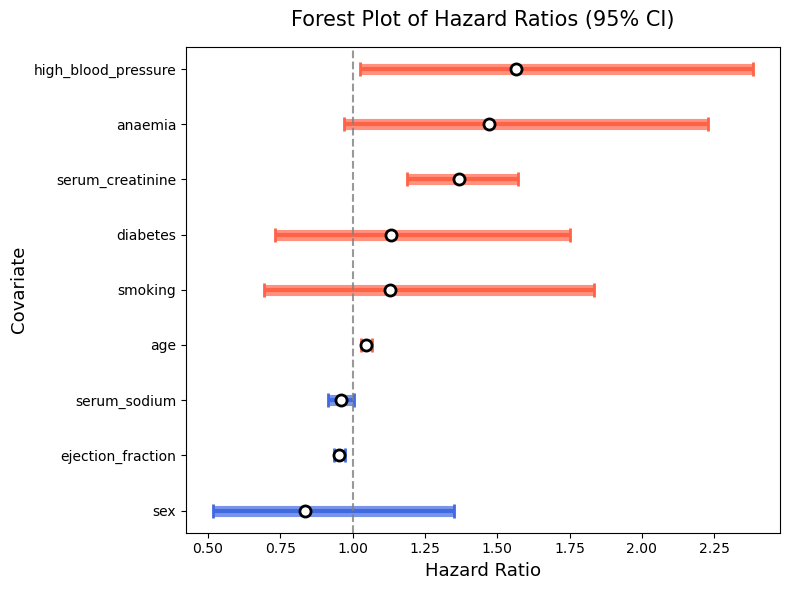


Hazard ratios for multi-unit changes in each covariate:
1. Every 10 years increase in age: Hazard ratio = 1.584
2. Presence of high blood pressure vs absence: Hazard ratio = 1.564
3. Presence of anaemia vs absence: Hazard ratio = 1.472
4. Every 1 mg/dL increase in serum creatinine: Hazard ratio = 1.368
5. Presence of diabetes vs absence: Hazard ratio = 1.133
6. Smoking vs non-smoking: Hazard ratio = 1.128
7. Female vs male: Hazard ratio = 0.837
8. Every 5 mmol/L increase in serum sodium: Hazard ratio = 0.809
9. Every 5% increase in ejection fraction: Hazard ratio = 0.788


<Figure size 600x400 with 0 Axes>

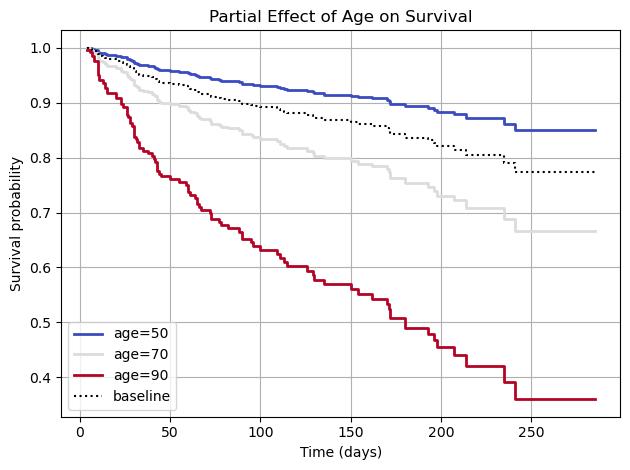

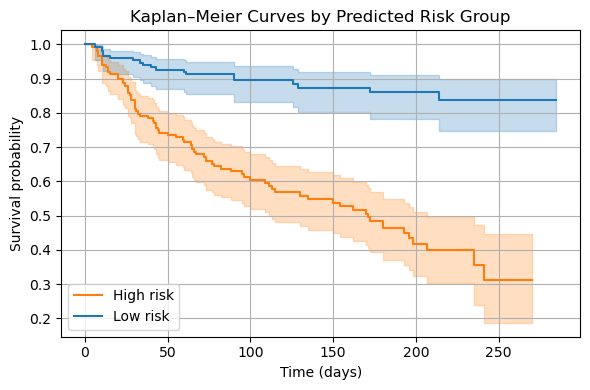

In [2]:
# ====== Part 1：导入库与环境配置 ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lifelines 用于 Cox 比例风险模型
from lifelines import CoxPHFitter, KaplanMeierFitter
# scikit-survival 用于随机生存森林
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
# sklearn 用于数据切分
from sklearn.model_selection import train_test_split

# ====== Part 2：数据读取与预处理======
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df["duration"] = df["time"]                         # 随访时间列
df["event"]    = df["DEATH_EVENT"].astype(bool)     # 事件列：是否死亡
covariates = [
    "age", "ejection_fraction", "serum_creatinine",
    "serum_sodium", "anaemia", "diabetes",
    "high_blood_pressure", "smoking", "sex"
]

# ====== Part 3：Cox 比例风险模型建立 ======
cph = CoxPHFitter()                                 # 实例化模型对象
cph.fit(
    df[["duration", "event"] + covariates],
    duration_col="duration",
    event_col="event"
)
print("\n=== Cox 模型汇总 ===")
print(cph.summary)

# ====== Part 4：可视化各变量的 Hazard Ratios ======
# 从 summary 中取出 HR 及其95%置信区间并整理为新 DataFrame
hr_df = cph.summary[["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%"]].copy()
hr_df.columns = ["HR", "CI_lower", "CI_upper"]
# 把原本的行索引（协变量名）写入新列，便于排序和显示
hr_df["Covariate"] = hr_df.index 

# 按 HR 值从大到小排序
hr_df = hr_df.sort_values("HR", ascending=False).reset_index(drop=True)  

# 用颜色区分效应方向：HR>1 用红色，HR<1 用蓝色
colors = hr_df["HR"].apply(lambda x: "tomato" if x > 1 else "royalblue")

# 绘制森林图
plt.figure(figsize=(8, 6))
# 逐行绘制点和误差线
for i, row in hr_df.iterrows():
    color = "tomato" if row["HR"] > 1 else "royalblue"
    plt.errorbar(
        x=row["HR"],  # HR 点估计
        y=i,  # y 轴为变量序号
        xerr=[[row["HR"] - row["CI_lower"]], [row["CI_upper"] - row["HR"]]],  # 左右误差
        fmt="o",  # 点的样式
        color="black",  # 误差线为黑色
        ecolor=color,  # 修正：使用单个颜色值而不是Series
        elinewidth=3,   # 误差线宽度
        capsize=5,      # 端帽长度
        markerfacecolor="white",  # 点心为白色
        markeredgewidth=2,        # 点边框加粗
        markersize=8              # 点的大小
    )
# 逐变量画水平粗线段
for i, row in hr_df.iterrows():
    color = "tomato" if row["HR"] > 1 else "royalblue"
    plt.hlines(
        y=i, xmin=row["CI_lower"], xmax=row["CI_upper"],
        color=color, alpha=0.7, linewidth=8, zorder=0
    )
# y 轴反转，使 HR 最大的变量排最上面
plt.gca().invert_yaxis()
# 设置 y 轴标签为变量名
plt.yticks(np.arange(len(hr_df)), hr_df["Covariate"])
# 画出 HR=1 的参考虚线
plt.axvline(1.0, color="gray", linestyle="--", linewidth=1.5, alpha=0.8)
# 图表标题与坐标轴标签
plt.title("Forest Plot of Hazard Ratios (95% CI)", fontsize=15, pad=15)
plt.xlabel("Hazard Ratio", fontsize=13)
plt.ylabel("Covariate", fontsize=13)
plt.tight_layout()
plt.show()

# ====== Part 5：量化多单位变化的风险比 ======
# 定义每个特征的单位变化，设定临床常用的递进步长
unit_dict = {
    "age": 10,  # per 10 years
    "ejection_fraction": 5,  # per 5%
    "serum_creatinine": 1,  # per 1 mg/dL
    "serum_sodium": 5,  # per 5 mmol/L
    "anaemia": 1,  # anaemia vs. non-anaemia
    "diabetes": 1,  # diabetes vs. non-diabetes
    "high_blood_pressure": 1,  # hypertension vs. normotension
    "smoking": 1,  # smoker vs. non-smoker
    "sex": 1,  # male vs. female
}

# 说明
desc_dict = {
    "age": "Every 10 years increase in age",
    "ejection_fraction": "Every 5% increase in ejection fraction",
    "serum_creatinine": "Every 1 mg/dL increase in serum creatinine",
    "serum_sodium": "Every 5 mmol/L increase in serum sodium",
    "anaemia": "Presence of anaemia vs absence",
    "diabetes": "Presence of diabetes vs absence",
    "high_blood_pressure": "Presence of high blood pressure vs absence",
    "smoking": "Smoking vs non-smoking",
    "sex": "Female vs male",
}

# 计算所有特征的多单位风险比
results = []
for var in covariates:
    coef = cph.params_[var]
    units = unit_dict[var]
    hr = np.exp(coef * units)
    desc = desc_dict[var]
    results.append((desc, hr))

# 按风险比降序排序
results.sort(key=lambda x: x[1], reverse=True)

# 有序列表输出
print("\nHazard ratios for multi-unit changes in each covariate:")
for idx, (desc, hr) in enumerate(results, 1):
    print(f"{idx}. {desc}: Hazard ratio = {hr:.3f}")

# ====== Part 6：局部效应可视化 ======
# 使用 CoxPHFitter 的方法直接绘制 partial effects
plt.figure(figsize=(6, 4))
cph.plot_partial_effects_on_outcome(
    covariates="age",
    values=[50, 70, 90],
    cmap="coolwarm",
    lw=2
)
plt.title("Partial Effect of Age on Survival")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.grid(True)
plt.tight_layout()
plt.show()

# ====== Part 7：Kaplan-Meier 曲线分组对比 ======
# 基于 Cox 模型风险分数将人群分为高/低风险
risk_scores = cph.predict_partial_hazard(df[covariates])
median_score = np.median(risk_scores)
df["risk_group"] = np.where(risk_scores >= median_score, "High risk", "Low risk")

# 指定颜色为 matplotlib C0 (蓝色) 和 C1 (橙色)
color_dict = {"High risk": "C1", "Low risk": "C0"}

kmf = KaplanMeierFitter()
plt.figure(figsize=(6, 4))
for name, group in df.groupby("risk_group"):
    kmf.fit(durations=group["duration"], event_observed=group["event"], label=name)
    kmf.plot_survival_function(ci_show=True, color=color_dict[name])
plt.title("Kaplan–Meier Curves by Predicted Risk Group")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.grid(True)
plt.tight_layout()
plt.show()
